# Parallelized Enrichment Analysis of Cell Types in Spatial Transcriptomics  


 

Description:  
This notebook performs an enrichment analysis of cell types surrounding tumor (HRS) cells in spatial transcriptomics data.  
The analysis quantifies the number of different cell types within a 200-micron radius of HRS cells and assesses statistical significance using a permutation-based z-score method.  

Key Steps:  
1. **Preprocessing Data:**
   - Generates a dictionary mapping cell types to their spatial indices.
   - Handles single-cell and doublet classifications for proper cell type assignments.
   
2. **Distance Computation:**
   - Constructs a pairwise Euclidean distance matrix to determine proximity between cells.

3. **Observed Mean Calculation:**
   - Computes the actual enrichment of each cell type around HRS cells.

4. **Permutation-Based Statistical Testing:**
   - Shuffles cell labels to create randomized distributions.
   - Uses parallel computing (multiprocessing) for efficient computation.
   - Computes the mean enrichment for each cell type across multiple permutations.
   - Compares shuffled means with observed means to compute p-values for statistical significance.

5. **Parallelization:**
   - Utilizes multiprocessing via `Pool` to accelerate computations.
   - Distributes computations across available CPU cores to handle thousands of cells efficiently.

Outputs:  
- Mean enrichment values for each cell type.  
- p-values (both one-sided up and down) indicating whether a cell type is significantly enriched or depleted around HRS cells.  

Author: Neriman Tokcan
Date: 2025



In [7]:
import tensorly as tl
from glob import glob
import os
import math
import scanpy as sc
import pandas as pd
import numpy as np
import sys
from tqdm import tqdm
import anndata
import timeit
from matplotlib import cm
import torch
from scipy import stats
import matplotlib.colors as mcolors
from tensorly.decomposition import tucker
from IPython.display import display
import seaborn as sns
#import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import scanpy as sc
import anndata as ad
from sklearn.preprocessing import StandardScaler
from IPython.display import display
import datetime
now = datetime.datetime.now()
import scipy.optimize
import scipy.stats
import csv
from scipy.sparse import csr_matrix
%pylab inline
from scipy.spatial import distance
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
from sklearn.preprocessing import StandardScaler
import matplotlib.patches as mpatch

import gzip, pickle
from scipy.spatial.distance import cdist
import pickle, pprint
from scipy import io
from six.moves import cPickle
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
#from scipy.sparse import csr_matrix
from scipy import sparse

import gzip
import shutil
import os
from sklearn.neighbors import NearestNeighbors

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [10]:
os.chdir("/home/ntokcan/Github_2025/Data")

In [11]:
### Reading the annotated data
with open('Puck_211018_31_anndata_normalized.pkl', 'rb') as h:
    adata = pickle.load(h)

## Creating the cell type dictionary 
- We are creating a cell_type_dictionary such that keys are the cell_types
- This dictionary maps each cell type to two lists:
  
       1- list of integer indices corresponding to that cell type.
       2- list of barcodes associated with that cell type.
To understand the code better, it is suggested to check adata.obs- 

The data has singlets & doublets|
    If it is doublet_uncertain and not HRS cell, we choose the first assignment
    If it is doublet_certain, we take both of the cell types as the final assignment
    This assignment can be already in the updated data- so it would be safe the skip the block of the code
    until the line starts with cell_types1
    We consider the the final assignment column at the end

In [12]:
def cell_types_dictionary(adata):  
    
    adata2=adata.obs.copy()
    #The data has singlets & doublets
    #If it is doublet_uncertain and not HRS cell, we choose the first assignment
    #If it is doublet_certain, we take both of the cell types as the final assignment
    #This assignment can be already in the updated data- so it would be safe the skip the block of the code
    #until the line starts with cell_types1
    #We consider the the final assignment column at the end
    for index, row  in adata2.iterrows():
        if (row["spot_class"]=="singlet") & (row["HRS_location"]==False):
       
            adata2.loc[index, "final_assignment"]= str(row["first_type"])
        if (row["spot_class"]=="doublet_uncertain") & (row["HRS_location"]==False):
            adata2.loc[index, "final_assignment"]= str(row["first_type"])
            
        if (row["spot_class"]=="doublet_certain") & (row["HRS_location"]==False):
            adata2.loc[index, "final_assignment"]=row["first_type"]+ "+" + row["second_type"]
    cell_types1=list(set(np.unique(adata2["first_type"].to_list())) - set(["tumor"]) -set(["nan"]))
    cell_types2=list(set(np.unique(adata2["second_type"].to_list())) - set(["tumor"]) -set(["nan"]))
    cell_types=list(set(cell_types1 + cell_types2))
    cell_types_dict={}
    adata3= adata2[~adata2["final_assignment"].isna()] 
    
    #we are creating a cell_type_dictionary such that keys are the cell_types
    #This dictionary maps each cell type to two lists:
       # 1-  list of integer indices corresponding to that cell type.
       #2- list of barcodes associated with that cell type.

    for i in range(0, len(cell_types)):
         cell_types_dict[cell_types[i]]=[[],[]]
        
    for index, row in adata3.iterrows():
        l=str(row["final_assignment"])
        s=l.split("+")
    
        if len(s)==1:
            c=str(s[0])
            cell_types_dict[c][0].append(row["integer_index"])
            
            cell_types_dict[c][1].append(row["barcodes"])
        if len(s)==2: #if we assign more than one self-time
            a=str(s[0])
            b=str(s[1])
        
            cell_types_dict[a][0].append(row["integer_index"])
            
            cell_types_dict[a][1].append(row["barcodes"])
        
            cell_types_dict[b][0].append(row["integer_index"])
            
            cell_types_dict[b][1].append(row["barcodes"])
    #adata_normalized.write("anndata_normalized.h5ad")
    f = open("cell_types_dict.pkl","wb")

    pickle.dump(cell_types_dict,f)
    f.close()
    
    
    return cell_types_dict

   

In [13]:
cell_types_dict=cell_types_dictionary(adata)

In [14]:
cell_types=list(cell_types_dict.keys())
cell_types

['Monocytes_macrophages',
 'Natural_killer_cells',
 'B_cells',
 'Plasmacytoid_dendritic cells',
 'CD4_T_cells',
 'CD8_T_cells',
 'Plasma_cells']

In [19]:
def multiple_figures_cell_types(adata, cell_types_dict, types, figure_size):
    colors=["green", "orange", "purple", "olive","black", "brown", "purple"]
   
    plt.figure(figsize=figure_size)
    #plt.suptitle("Puck_"+puck_number, fontsize=20)
    adata_tumor=adata.obs[adata.obs["HRS_location"]==True]
    #plt.subplot(1, len(types)+1,1)
    
    #plt.scatter(adata.obs["xcoord"], adata.obs["ycoord"], s=1, alpha=0.1, color="gray")
        
    #plt.scatter(adata_tumor["xcoord"], adata_tumor["ycoord"], s=1, alpha=1, color="red", label="tumor")
   # barcodes_list=cell_types_dict[types[3]][1]
   # adata_cell=adata.obs[adata.obs.barcodes.isin(barcodes_list)]
        
    #plt.scatter(adata_cell["xcoord"], adata_cell["ycoord"], s=1, alpha=1, color=colors[3], label=types[3])
   # plt.legend(bbox_to_anchor=(0.01, 1.01), loc='upper left', borderaxespad=0,markerscale=4, scatterpoints=1, fontsize=15,frameon=True)

    
    for i in range(0, len(types)):
        plt.subplot(1, len(types), i+1)
        barcodes_list=cell_types_dict[types[i]][1]
        adata_cell=adata.obs[adata.obs.barcodes.isin(barcodes_list)]
        plt.axis("off")
        plt.scatter(adata.obs["xcoord"], adata.obs["ycoord"], s=1, alpha=0.1, color="gray")

        plt.scatter(adata_cell["xcoord"], adata_cell["ycoord"], s=1.5, alpha=1, color=colors[i], label=types[i])
        
        plt.scatter(adata_tumor["xcoord"], adata_tumor["ycoord"], s=2, alpha=1, color="red", label="tumor")
        
        #plt.scatter(adata_f["xcoord"], adata_f["ycoord"], s=0.3, alpha=1, color="yellow")
        plt.legend(bbox_to_anchor=(0.1, 1.21), loc='upper left', borderaxespad=0,markerscale=4, scatterpoints=1, fontsize=15,frameon=True)
    plt.show()   
    #plt.savefig

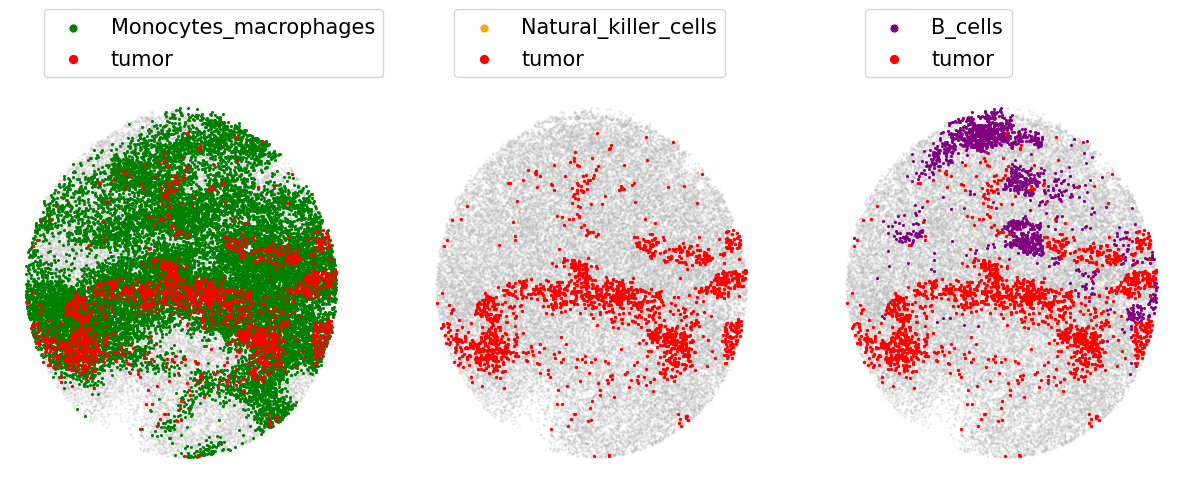

In [20]:
multiple_figures_cell_types(adata, cell_types_dict, cell_types[:3], (15,5))

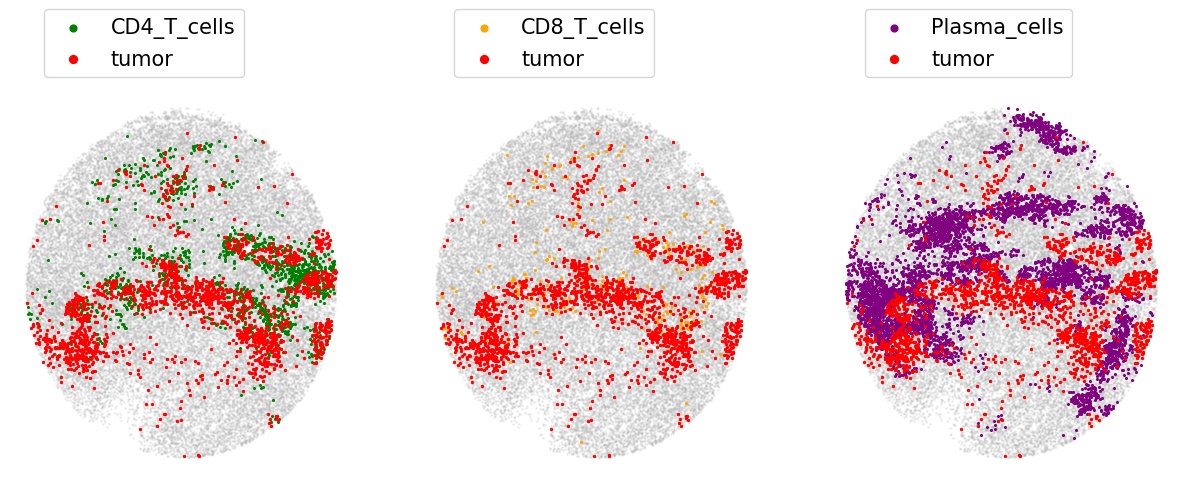

In [22]:
multiple_figures_cell_types(adata, cell_types_dict, cell_types[4:7], (15,5))

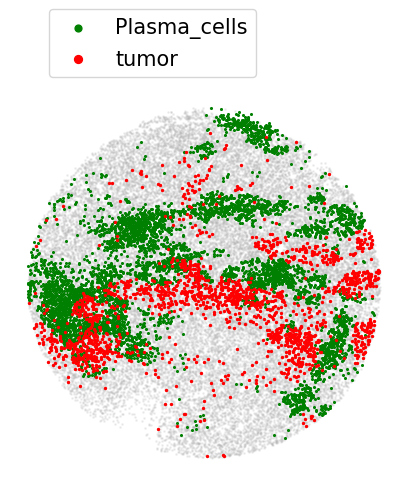

In [24]:
multiple_figures_cell_types(adata, cell_types_dict, cell_types[-1:], (5,5))

## Enrichment_analysis 

 This code analyzes spatial trancriptomics data  from CHL patients to quantify the enrichment of specific cell types  in the vicinity of malignant Hodgkin Reed-Sternberg (HRS) cells. We apply a permutation test to assess  
statistical significance.  


In [90]:
# This code analyzes spatial trancriptomics data  from CHL patients to quantify the enrichment of specific cell types  in the vicinity of malignant Hodgkin Reed-Sternberg (HRS) cells. We apply a permutation test to assess  
# statistical significance.  


True

In [25]:
from multiprocessing import Pool, cpu_count
from joblib import Parallel, delayed
import time

#Parallel computing is used because the analysis involves thousands of cells and multiple permutations.


#orig_indices: assigned indices as sample identifiers corresponding to different locations
#cell_types_dict: A dictionary mapping cell type names to locations
#cell_types: A list of the 14 cell types analyzed.
#adata_tumor_indices: Indices of tumor (HRS) cells in the dataset.
#Distance: A distance matrix or metric measuring proximity between cells.
#observed_means: The actual observed means of cell type distributions around HRS cells.
#thread_num: Thread identifier for parallel computing

class z_score_thread_param:
        
    def __init__(self, orig_indices, cell_types_dict, cell_types, adata_tumor_indices, Distance, observed_means, thread_num):
        self.orig_indices = orig_indices
        self.cell_types_dict = cell_types_dict
        self.cell_types = cell_types
        self.adata_tumor_indices = adata_tumor_indices
        self.observed_means = observed_means
        self.thread_num = thread_num
        self.distance = Distance
        
        self.means = np.zeros(len(cell_types))#len(cell_types)) #A NumPy array initialized to zeros, intended to store computed means for each of the 14 cell types.
        self.pvalues_up = np.zeros(len(cell_types))#len(cell_types)) 
        self.pvalues_down = np.zeros(len(cell_types))#len(cell_types))


    def reset(self):
        self.orig_indices = 0
        self.cell_types_dict = 0
        self.cell_types = 0
        self.adata_tumor_indices = 0
        self.observed_means = 0
        self.thread_num = 0
        self.distance = 0
        
#__enrichment_thread() Function
#Steps
#1 Initialize variables from thread_param (input from z_score_thread_param).
#2 Shuffle the cell indices to randomize spatial positions.
#3 Measure the number of cells within 200 microns of each HRS cell.
#4 Compute mean enrichment for each cell type.
#5 Compare shuffled means with observed means to compute statistical significance:
#6 If shuffled mean exceeds the observed mean → pvalues_up increases.
#7 If shuffled mean falls below the observed mean → pvalues_down increases.
#8 Reset the parameters and return the results.
        
def __enrichment_thread(thread_param):
        n = thread_param.thread_num
        
        #print("Thread number started: ", n)
        
        adata_tumor_indices = thread_param.adata_tumor_indices
        cell_types = thread_param.cell_types
        cell_types_dict = thread_param.cell_types_dict
        lt=len(adata_tumor_indices)
        m = thread_param.observed_means
        Distance = thread_param.distance

        for k in range(n*200, (n+1)*200):
            #print("Thread " + str(n) + " iteration " + str(k));
            random.seed(k)
            indices1=thread_param.orig_indices
            random.shuffle(indices1)
            a,b=np.where(Distance[indices1[adata_tumor_indices]] <200)
       
            c,d=np.unique(b, return_counts=True)
            dict_c = {c[i]: d[i] for i in range(len(d))}
            for j in range(0, len(thread_param.cell_types)):
                x= (sum([dict_c[indices1[x]] for x in cell_types_dict[cell_types[j]][0] if indices1[x] in c]) / lt)
                thread_param.means[j] += x
                if x > m[j]:
                    thread_param.pvalues_up[j] += 1
                if x < m[j]:  
                    thread_param.pvalues_down[j] += 1

        thread_param.reset()
       # print("Thread number done: " + str(k) + " .") #
    
        return thread_param




def cell_types_dictionary(adata):  
    
    adata2=adata.obs.copy()
    #The data has singlets & doublets
    #If it is doublet_uncertain and not HRS cell, we choose the first assignment
    #If it is doublet_certain, we take both of the cell types as the final assignment
    #This assignment can be already in the updated data- so it would be safe the skip the block of the code
    #until the line starts with cell_types1
    #We consider the the final assignment column at the end
    for index, row  in adata2.iterrows():
        if (row["spot_class"]=="singlet") & (row["HRS_location"]==False):
       
            adata2.loc[index, "final_assignment"]= str(row["first_type"])
        if (row["spot_class"]=="doublet_uncertain") & (row["HRS_location"]==False):
            adata2.loc[index, "final_assignment"]= str(row["first_type"])
            
        if (row["spot_class"]=="doublet_certain") & (row["HRS_location"]==False):
            adata2.loc[index, "final_assignment"]=row["first_type"]+ "+" + row["second_type"]
    cell_types1=list(set(np.unique(adata2["first_type"].to_list())) - set(["tumor"]) -set(["nan"]))
    cell_types2=list(set(np.unique(adata2["second_type"].to_list())) - set(["tumor"]) -set(["nan"]))
    cell_types=list(set(cell_types1 + cell_types2))
    cell_types_dict={}
    adata3= adata2[~adata2["final_assignment"].isna()] 
    
    #we are creating a cell_type_dictionary such that keys are the cell_types
    #This dictionary maps each cell type to two lists:
       # 1-  list of integer indices corresponding to that cell type.
       #2- list of barcodes associated with that cell type.

    for i in range(0, len(cell_types)):
         cell_types_dict[cell_types[i]]=[[],[]]
        
    for index, row in adata3.iterrows():
        l=str(row["final_assignment"])
        s=l.split("+")
    
        if len(s)==1:
            c=str(s[0])
            cell_types_dict[c][0].append(row["integer_index"])
            
            cell_types_dict[c][1].append(row["barcodes"])
        if len(s)==2: #if we assign more than one self-time
            a=str(s[0])
            b=str(s[1])
        
            cell_types_dict[a][0].append(row["integer_index"])
            
            cell_types_dict[a][1].append(row["barcodes"])
        
            cell_types_dict[b][0].append(row["integer_index"])
            
            cell_types_dict[b][1].append(row["barcodes"])
    #adata_normalized.write("anndata_normalized.h5ad")
    f = open("cell_types_dict.pkl","wb")

    pickle.dump(cell_types_dict,f)
    f.close()
    
    
    return cell_types_dict

       
            
def enrichment_of_cell_types_z_score_parallel(adata, shuffle_number):
    shuff_no=shuffle_number
    cell_types_dict=cell_types_dictionary(adata)
    cell_types=list(cell_types_dict.keys())
   
    x=adata.obs["xcoord"].to_list()
    y=adata.obs["ycoord"].to_list()
    adata_tumor=adata[adata.obs["HRS_location"]=="True"]
   
    if len(adata_tumor)==0:
        adata_tumor=adata[adata.obs["HRS_location"]==True]
    lt=len(adata_tumor)    
    coords=[(i*0.65,j*0.65) for i,j in zip(x,y)]
    adata_tumor_indices=adata_tumor.obs.integer_index.to_list()
    Distance=distance.cdist(coords, coords, 'euclidean') 

    indices=np.arange(0,len(adata.obs))

    a,b=np.where(Distance[indices[adata_tumor_indices]] <200)
    c,d=np.unique(b, return_counts=True)
    dict_c = {c[i]: d[i] for i in range(len(d))}
    m=[]
    for j in range(0, len(cell_types)):
        m.append(sum([dict_c[x] for x in cell_types_dict[cell_types[j]][0] if x in c]) / lt)  
 
    print("Calculated average cells within 200 microns of HRS cells based on the cell types") 
    print(m)
    
    ### Prep the parallel threads
    params = []
    for k in range(0, shuffle_number):
        params.append(z_score_thread_param(indices, cell_types_dict, cell_types, adata_tumor_indices, Distance, m, k))
        #params.append(z_score_thread_param(0, 0, 0, 0, 0, 0, k))

    print(f'Starting computation on {cpu_count()} CPUs')  
    #Note we can run it thorugh multiple pucks, now I just show in 1 
    #If we are running on cpu, recommended gpu
    pool_n= min(100, os.cpu_count())

    with Pool(pool_n) as pool:
        res = pool.map(__enrichment_thread, params)

    #Parallel(n_jobs=30)(delayed(__enrichment_thread)(p) for p in params) 
    
    ### Merge the result from the parallel threads
    
    means = np.zeros(len(cell_types))
    pvalues_up = np.zeros(len(cell_types))
    pvalues_down = np.zeros(len(cell_types))

    for k in range(0, shuffle_number):
        means += res[k].means
        pvalues_up += res[k].pvalues_up
        pvalues_down += res[k].pvalues_down
        
    means = means  / (shuff_no)
    enrichment_pvalues_up = (pvalues_up +1) / (shuff_no +1)
    enrichment_pvalues_down = (pvalues_down +1) / (shuff_no +1)
    enrichment_zscores= np.subtract(np.array(m), np.array(means))
    enrichment_zscores=[m[i]/ means[i] for i in range(len(m))]
    
    print("z scores are:", enrichment_zscores)
    print("upper p values are:", enrichment_pvalues_up)
    print("lower p values are:", enrichment_pvalues_down)
    enrichment_zscores_df=pd.DataFrame(enrichment_zscores, index=cell_types)
    enrichment_pvalues_up_df=pd.DataFrame(enrichment_pvalues_up, index=cell_types)
    enrichment_pvalues_down_df=pd.DataFrame(enrichment_pvalues_down, index=cell_types)
    enrichment_pvalues_up_df.to_csv("p_values_up.csv")    
    enrichment_pvalues_down_df.to_csv("p_values_down.csv")
    enrichment_zscores_df.to_csv("enrichment_zscores.csv")
    
    return enrichment_zscores_df, enrichment_pvalues_up, enrichment_pvalues_down

#p="211008_07"
#shuf_number=5
#pool_num=30
#try:
   # print("WORKING ON PUCK " + p)
   # enrichment_zscores, enrichment_pvalues_up, enrichment_pvalues_down=enrichment_of_cell_types_z_score_parallel(adata, shuf_number, pool_num)
   # pd.DataFrame(enrichment_pvalues_up).to_csv("p_values_up.csv", header=None)    
   # pd.DataFrame(enrichment_pvalues_down).to_csv("p_values_down.csv", header=None)
   # pd.DataFrame(enrichment_zscores).to_csv("enrichment_zscores.csv", header=None)
    
#except:
    #print("Aborting puck " + p)
    #pass


In [26]:
shuf_number=100
enrichment_zscores, enrichment_pvalues_up, enrichment_pvalues_down=enrichment_of_cell_types_z_score_parallel(adata, shuf_number)


Calculated average cells within 200 microns of HRS cells based on the cell types
[462.6570945945946, 0.0, 10.276463963963964, 0.03322072072072072, 48.72353603603604, 10.99831081081081, 106.0518018018018]
Starting computation on 30 CPUs
z scores are: [0.007155214337432379, nan, 0.0017707786691972404, 0.0040805147811460865, 0.009758364290782579, 0.00951618062748534, 0.005394264142165024]
upper p values are: [9.90099010e-03 9.90099010e-03 1.98029703e+02 1.64069307e+02
 9.90099010e-03 9.90099010e-03 9.90099010e-03]
lower p values are: [1.98029703e+02 9.90099010e-03 9.90099010e-03 3.06732673e+01
 1.98029703e+02 1.98029703e+02 1.98029703e+02]


/tmp/ipykernel_19612/1075974728.py:211: RuntimeWarning: invalid value encountered in double_scalars
  enrichment_zscores=[m[i]/ means[i] for i in range(len(m))]
